In [86]:
import karhunenLoeve as kl
from matplotlib import pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
import numpy as np
import time
from scipy.special import kv, gamma
from  scipy.optimize import brentq

import graphSettings

testing of integrals in the Galerkin Method for Spectral Decomposition

## 1D
#### Calculation of W matrix
should be identity matrix due to orthogonality

[[ 1.00000000e+00  7.07767178e-16 -4.59875193e-15  5.29784550e-15]
 [ 7.07767178e-16  1.00000000e+00  5.26510259e-15 -5.97178557e-15]
 [-4.59875193e-15  5.26510259e-15  1.00000000e+00  5.12263842e-15]
 [ 5.29784550e-15 -5.97178557e-15  5.12263842e-15  1.00000000e+00]]


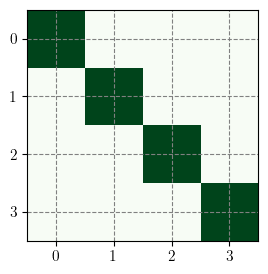

In [35]:

l = lambda x : kl.integ.legendre_normal(x, 100)

matrix_size = 4
matrix = np.zeros((matrix_size,matrix_size))
for i in range(matrix_size):
    for j in range(matrix_size):
        matrix[i,j] = kl.integ.quadrature(lambda x : l(x)[i]*l(x)[j], 100)
print(matrix)

# plot
fig, ax = plt.subplots()


ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()

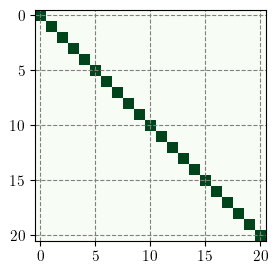

In [36]:
l = lambda x : kl.integ.legendre_normal(x, 20)

n = 50


nodes, weights = kl.integ.nodes_weights(n)

values = l(nodes)


matrix = ((values * weights) @ values.T)
#print(values)
#print(values * weights)


# plot
fig, ax = plt.subplots()

ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()


with interval <a,b>:

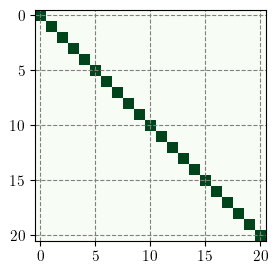

In [37]:
a = 0
b = 5
l = lambda x : kl.integ.legendre_normal(((a+b)/(a-b) + (2/(b-a))*x), 20)

n = 50


nodes, weights = kl.integ.nodes_weights(n)

nodes = (a+b)/2 + (b-a)/2*nodes
weights = weights * (b-a)/2

values = l(nodes)


matrix = ((values * weights) @ values.T)
#print(values)
#print(values * weights)

# plot
fig, ax = plt.subplots()

ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()

## Covariance function

(copied:)

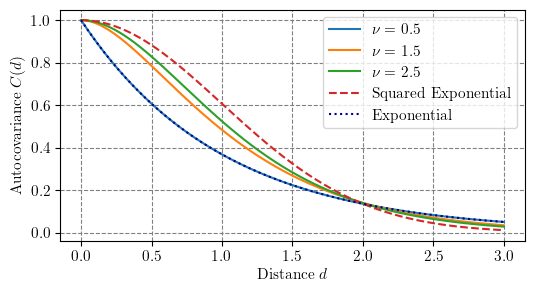

In [84]:
# Define parameters
length_scale = 1.0
variance = 1.0
distances = np.linspace(0, 3, 500)

# Define Matérn covariance function
def matern_covariance(d, l, sigma2, nu):
    if np.any(d < 0):
        raise ValueError("Distance d cannot be negative.")
    
    d_safe = np.where(d == 0, 1e-10, d) # Use a small epsilon instead of 0
    const_part = sigma2 * (2**(1 - nu)) / gamma(nu)
    scaled_dist = np.sqrt(2 * nu) * d_safe / l
    bessel_part = kv(nu, scaled_dist)
    
    cov = const_part * (scaled_dist**nu) * bessel_part
    
    cov[d == 0] = sigma2 
    
    if nu == 0.5:
        cov = sigma2 * np.exp(-d / l)
    elif nu == 1.5:
        cov = sigma2 * (1 + np.sqrt(3) * d / l) * np.exp(-np.sqrt(3) * d / l)
    elif nu == 2.5:
        cov = sigma2 * (1 + np.sqrt(5) * d / l + 5 * d**2 / (3 * l**2)) * np.exp(-np.sqrt(5) * d / l)
        
    return cov

# Smoothness parameters to plot
nus = [0.5, 1.5, 2.5]

for nu in nus:
    cov = matern_covariance(distances, length_scale, variance, nu)
    plt.plot(distances, cov, label=f'$\\nu = {nu}$')

# Calculate Squared Exponential (Gaussian) covariance
sq_exp_cov = variance * np.exp(-(distances**2) / (2 * length_scale**2))
plt.plot(distances, sq_exp_cov, label='Squared Exponential', linestyle='--')

# Calculate Exponential covariance
exp_cov = variance * np.exp(-distances / length_scale)
plt.plot(distances, exp_cov, label='Exponential', linestyle=':', color="darkblue")

#plt.title('Covariance Functions ($l=1, \\sigma^2=1$)')
plt.xlabel('Distance $d$')
plt.ylabel('Autocovariance $C(d)$')
plt.legend()
plt.savefig("CovarienceFunctions.pdf", bbox_inches='tight')
plt.show()

### Intagral with Covariance funtion

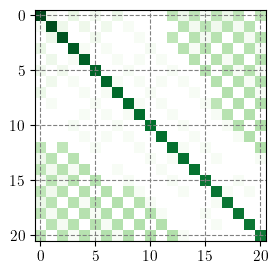

(100, 100)

In [92]:
l = lambda x : kl.integ.legendre_normal(x, 20)
cov = lambda x,y : np.exp(-np.abs(x-y))

#dist_sq = x**2 + y**2
#dist = np.sqrt(dist_sq) = np.sqrt(x**2 + y**2)
length_scale = 1.0
exp_cov = lambda x,y : variance * np.exp(-np.sqrt(x**2 + y**2) / length_scale)
sq_exp_cov = lambda x,y : variance * np.exp(-(x**2 + y**2) / (2 * length_scale**2))

n = 100


nodes, weights = kl.integ.nodes_weights(n)

nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l(nodes)

#print(cov(nodesx, nodesy))

A = (values * weights)
matrix = A @ (cov(nodesx, nodesy) )@ A.T
#print(matrix)

# plot
fig, ax = plt.subplots()

#ax.imshow(matrix, cmap=colormaps['Greens'])
ax.imshow(matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

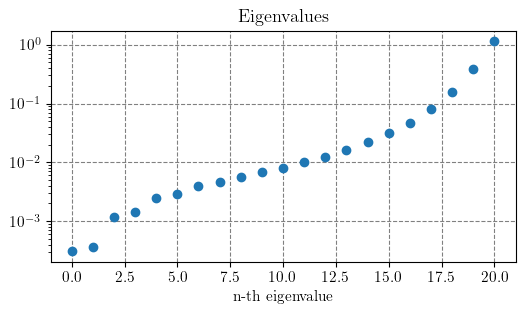

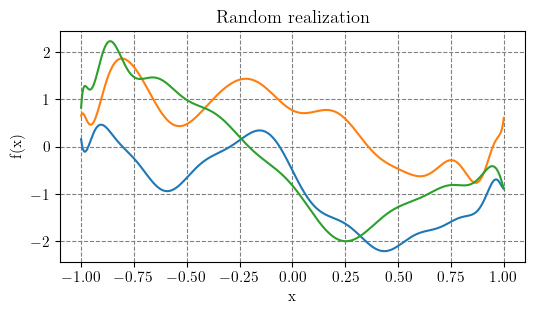

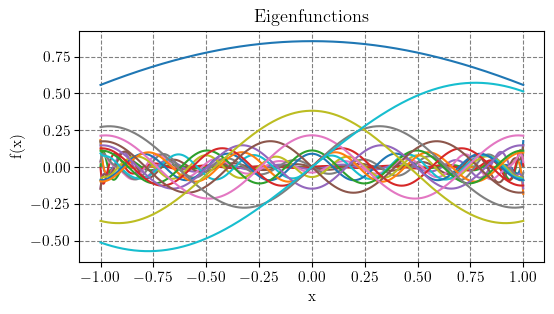

In [89]:
# eigendecomposition of matrix
eigenvalues, eigenvectors = np.linalg.eigh(matrix)
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)
eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))

# random realization
n = eigenvectors_functions.shape[1]

plt.title('Eigenvalues')
plt.plot(eigenvalues, 'o')
plt.yscale("log")
plt.xlabel('n-th eigenvalue')
plt.show()

for i in range(3):
    realisation = np.random.normal(size=n)
    realisation = eigenvectors_functions @ realisation

    plt.plot(x_axis, realisation)

plt.title('Random realization')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


# eigenfunctions visualization
for fnc in eigenvectors_functions.T:
    plt.plot(x_axis, fnc)
plt.title('Eigenfunctions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [ ]:
def KL_exp_1D(L, nu, sigma_squared, N):
    """
    First N eigenpairs of the exponential kernel CY(x,y)=sigma_squared·exp(-|x-y|/nu) on [0,L].

    Returns
    -------
    lambdas: (N,) ndarray         # eigenvalues k_n  (Eq. A.8)
    f      : list of callables    # eigenfunctions f_n(x) (Eqs. A.5, A.10)
    """
    # characteristic eq. (g²w²−1)sin(wL)=2gw cos(wL)  — Eq. A.7
    ce = lambda w: (nu**2 * w**2 - 1) * np.sin(w * L) - 2 * nu * w * np.cos(w * L)

    w, n, eps = [], 1, 1e-12  # positive roots w_n
    for n in range(1, N + 1):
        a, b = (n - 1) * np.pi / L + eps, n * np.pi / L - eps    # bracket ( (n-1)π/L , nπ/L )
        w.append(brentq(ce, a, b))
    
    w = np.asarray(w)
    lambdas = 2 * nu * sigma_squared / (nu**2 * w**2 + 1.0)          # Eq. A.8
    b = 1 / np.sqrt((nu**2 * w**2 + 1) * L / 2 + nu)           # Eq. A.10
    a = nu * w * b

    # vectorised eigenfunction handles f_n(x)=a_n cos(w_n x)+b_n sin(w_n x)
    f = [(lambda a_, b_, w_: (lambda x, a=a_, b=b_, w=w_: a * np.cos(w * x) + b * np.sin(w * x)))
         (ai, bi, wi) for ai, bi, wi in zip(a, b, w)]
    return lambdas, f
KL_exp_1D(2, 1, 1, 10)

(array([1.14931043, 0.39094124, 0.15704921, 0.07955658, 0.04712668,
        0.03093145, 0.02178454, 0.01614346, 0.01242983, 0.00985944]),
 [<function __main__.KL_exp_1D.<locals>.<listcomp>.<lambda>.<locals>.<lambda>(x, a=0.5197300376093048, b=0.6041029250080778, w=0.8603335890193797)>,
  <function __main__.KL_exp_1D.<locals>.<listcomp>.<lambda>.<locals>.<lambda>(x, a=0.8203543798409895, b=0.40436288867532444, w=2.0287578381103057)>,
  <function __main__.KL_exp_1D.<locals>.<listcomp>.<lambda>.<locals>.<lambda>(x, a=0.9243295617499787, b=0.26982852080079694, w=3.42561845948217)>,
  <function __main__.KL_exp_1D.<locals>.<listcomp>.<lambda>.<locals>.<lambda>(x, a=0.9609822995161024, b=0.19559271460965008, w=4.913180439434884)>,
  <function __main__.KL_exp_1D.<locals>.<listcomp>.<lambda>.<locals>.<lambda>(x, a=0.9767078482286602, b=0.1517263642359831, w=6.437298179171859)>,
  <function __main__.KL_exp_1D.<locals>.<listcomp>.<lambda>.<locals>.<lambda>(x, a=0.9846520402392511, b=0.12341061472

### Residuum:

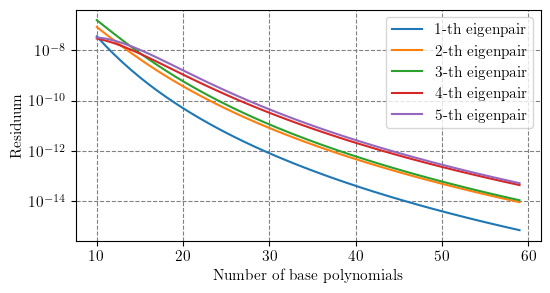

In [90]:
cov = lambda x,y : np.exp(-np.abs(x-y))

for i in range(1,6):
    residuum_i = []
    node_range=range(10,60)
    for n in node_range:
        l = lambda x : kl.integ.legendre_normal(x, n)
        
        nodes, weights = kl.integ.nodes_weights(200)
        nodesx, nodesy = np.meshgrid(nodes,nodes)

        values = l(nodes)

        A = (values * weights)
        C = cov(nodesx, nodesy)
        matrix = A @ C @ A.T

        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        #print(values.T.shape, eigenvectors.shape, matrix.shape)
        eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))
        
        eigf = eigenvectors_functions.T[i]
        eigv = eigenvalues[i]

        left_side = C@(eigf*weights)
        right_side = -eigv*eigf

        residuum_i.append(weights @ ((left_side + right_side)**2))
    plt.plot(node_range,residuum_i, label=f'{i}-th eigenpair')
plt.xlabel("Number of base polynomials")
plt.ylabel("Residuum")
plt.legend()
plt.yscale("log")
plt.savefig("EigenpairsResiduum.pdf", bbox_inches='tight')
plt.show()

#### Trying over <a,b>:

(21, 50)


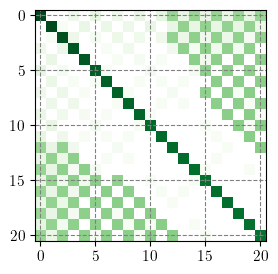

In [12]:
a = -2
b = 1
l = lambda x : kl.integ.legendre_normal(x, 20)
cov = lambda x,y : np.exp(-np.abs(x-y))

n = 50


nodes, weights = kl.integ.nodes_weights(n)

nodes = (a+b)/2 + (b-a)/2*nodes
weights = weights * (b-a)/2


nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l((a+b)/(a-b) + (2/(b-a))*nodes)

#print(cov(nodesx, nodesy))
A = (values* weights)
matrix = A @ cov(nodesx, nodesy) @ A.T
#print(matrix)

#print(weights.shape)
#print(nodes.shape)
print(values.shape)
#print(cov(nodesx, nodesy).shape)
#print(matrix.shape)


# plot
fig, ax = plt.subplots()

#ax.imshow(matrix, cmap=colormaps['Greens'])
ax.imshow(matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

(21, 1000) (21,) (21, 21) (1000, 21)
(1000, 21) (21,)


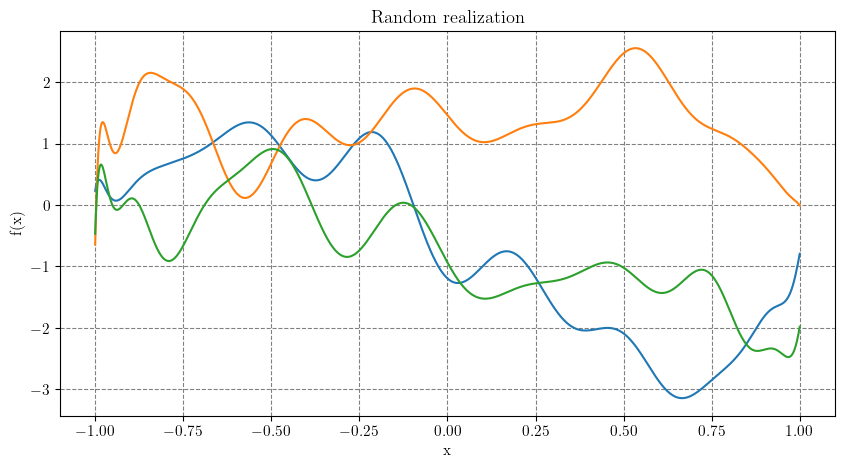

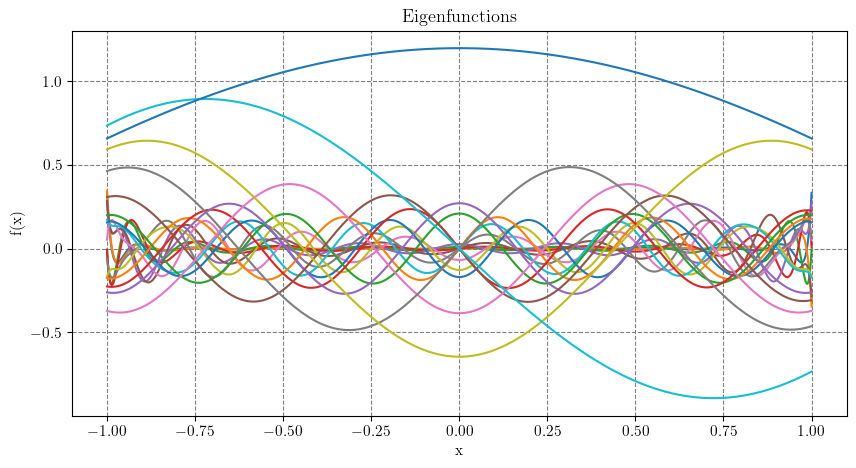

In [13]:
# eigendecomposition of matrix
eigenvalues, eigenvectors = np.linalg.eigh(matrix)
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)
eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))
print(values.shape, eigenvalues.shape, eigenvectors.shape, eigenvectors_functions.shape)
print((values.T @ eigenvectors).shape, np.sqrt(np.maximum(eigenvalues, 0)).shape)

# random realization
n = eigenvectors_functions.shape[1]

plt.figure(figsize=(10, 5))
for i in range(3):
    realisation = np.random.normal(size=n)
    realisation = eigenvectors_functions @ realisation

    plt.plot(x_axis, realisation)


plt.title('Random realization')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


# eigenfunctions visualization
plt.figure(figsize=(10, 5))
for fnc in eigenvectors_functions.T:
    plt.plot(x_axis, fnc)
plt.title('Eigenfunctions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

---
## 2D

Obtaining a 4D tensor A and making it into 2D tensor

In [14]:
poly_count = 18
l = lambda x: kl.integ.legendre_normal(x, poly_count)
#cov = lambda x1, x2, y1, y2 : np.exp(-np.abs( np.sqrt( (x1-x2)**2+(y1-y2)**2 )))

n = 100


nodes, weights = kl.integ.nodes_weights(n)

#nodesx1, nodesx2, nodesy1, nodesy2 = np.meshgrid(nodes, nodes, nodes, nodes)
nodesx1 = np.reshape(nodes, (-1, 1, 1, 1))
nodesy1 = np.reshape(nodes, (1, -1, 1, 1))
nodesx2 = np.reshape(nodes, (1, 1, -1, 1))
nodesy2 = np.reshape(nodes, (1, 1, 1, -1))
values = l(nodes)

#print(cov(nodesx1, nodesx2, nodesy1, nodesy2).shape)
#print(values.shape)
dist_sq = (nodesx1 - nodesx2)**2 + (nodesy1 - nodesy2)**2
lamb = 10
C_tensor = np.exp(-np.sqrt(dist_sq)/lamb)


#matrix = (values* weights) @ cov(nodesx1, nodesx2, nodesy1, nodesy2) @ (values.T * weights[:, np.newaxis])
PW = (values* weights)
A_tensor = np.einsum('kp,lq,pqrs,ir,js->klij', PW, PW, C_tensor, PW, PW, optimize=True)
A_tensor.shape
A_matrix = np.reshape(A_tensor, ((poly_count+1)**2,(poly_count+1)**2))

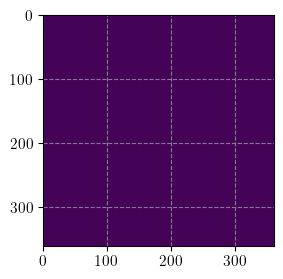

In [15]:
plt.imshow(A_matrix)

Making eigenfunctions (inefficient):

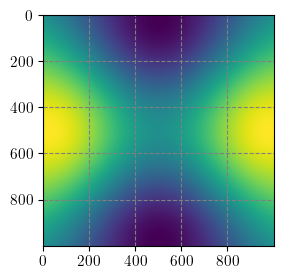

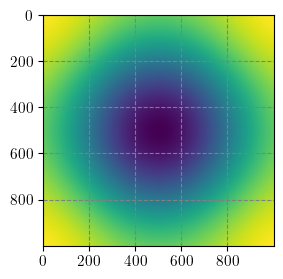

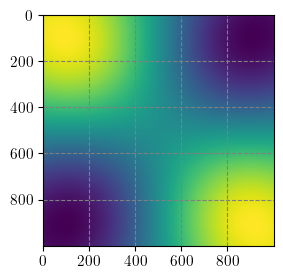

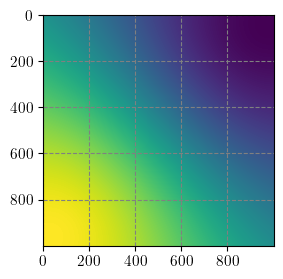

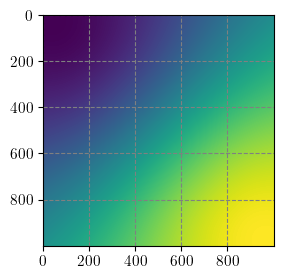

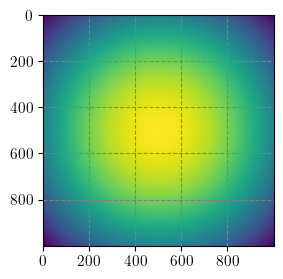

In [16]:
eigenvalues, eigenvectors = np.linalg.eigh(A_matrix)
#A = 1
#print((eigenvalues[A] * eigenvectors[:,A])- (A_matrix @ eigenvectors[:,A]))
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)
for eivec in range((poly_count+1)**2-6,(poly_count+1)**2):
    sum = 0
    for i in range(len(values)):
        for j in range(len(values)):
            sum+=values[i]*values[j][:, np.newaxis]*eigenvectors[i*(poly_count+1)+j,eivec] *np.sqrt(np.maximum(eigenvalues[eivec], 0))
    plt.imshow(sum)
    plt.show()



Making eigenfunctions:

In [17]:
eigenvalues, eigenvectors = np.linalg.eigh(A_matrix)
#A = 1
#print((eigenvalues[A] * eigenvectors[:,A])- (A_matrix @ eigenvectors[:,A]))
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)

# Perform broadcasted multiplication
V1 = values[:, np.newaxis, np.newaxis, :] # Shape (L, 1, 1, N)
V2 = values[np.newaxis, :, :, np.newaxis] # Shape (1, L, N, 1)
V = V1 * V2
V = np.reshape(V, (len(V)**2,len(x_axis),len(x_axis)))
#print(V.shape)
eigenvectors_functions = (np.einsum('ijk,in->njk', V, eigenvectors, optimize=True).T * np.sqrt(np.maximum(eigenvalues, 0))).T
    

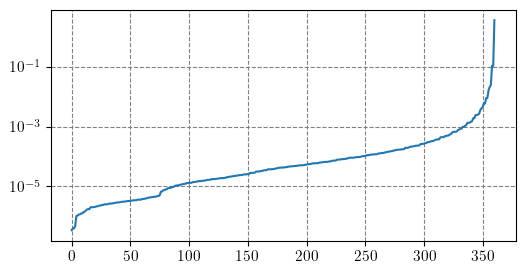

In [18]:
plt.plot(eigenvalues)
plt.yscale('log')
plt.show()

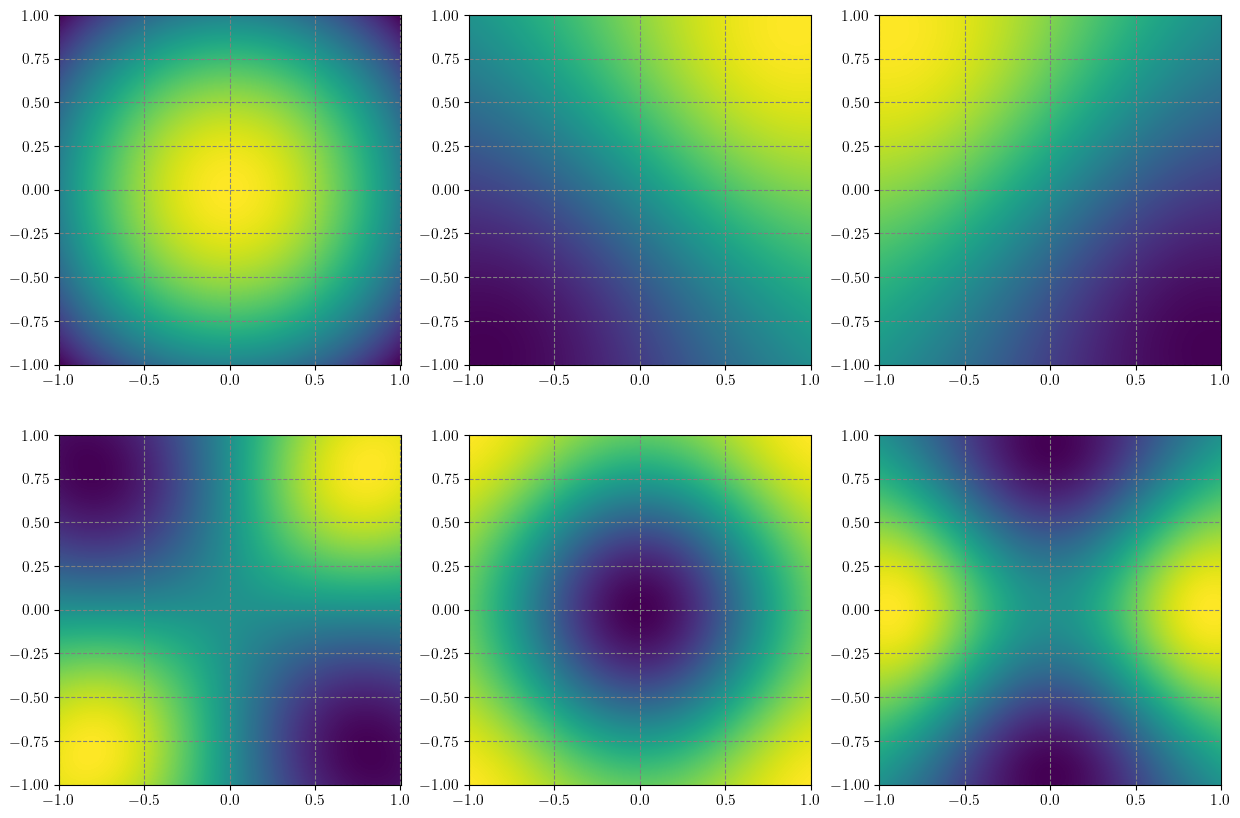

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    if(i<3): 
        axs[0,i].pcolormesh(x_axis, x_axis, eigenvectors_functions[-i-1])
    else:
        axs[1,i-3].pcolormesh(x_axis, x_axis, eigenvectors_functions[-i-1])
plt.show()

Random fields samples:

<Figure size 1000x500 with 0 Axes>

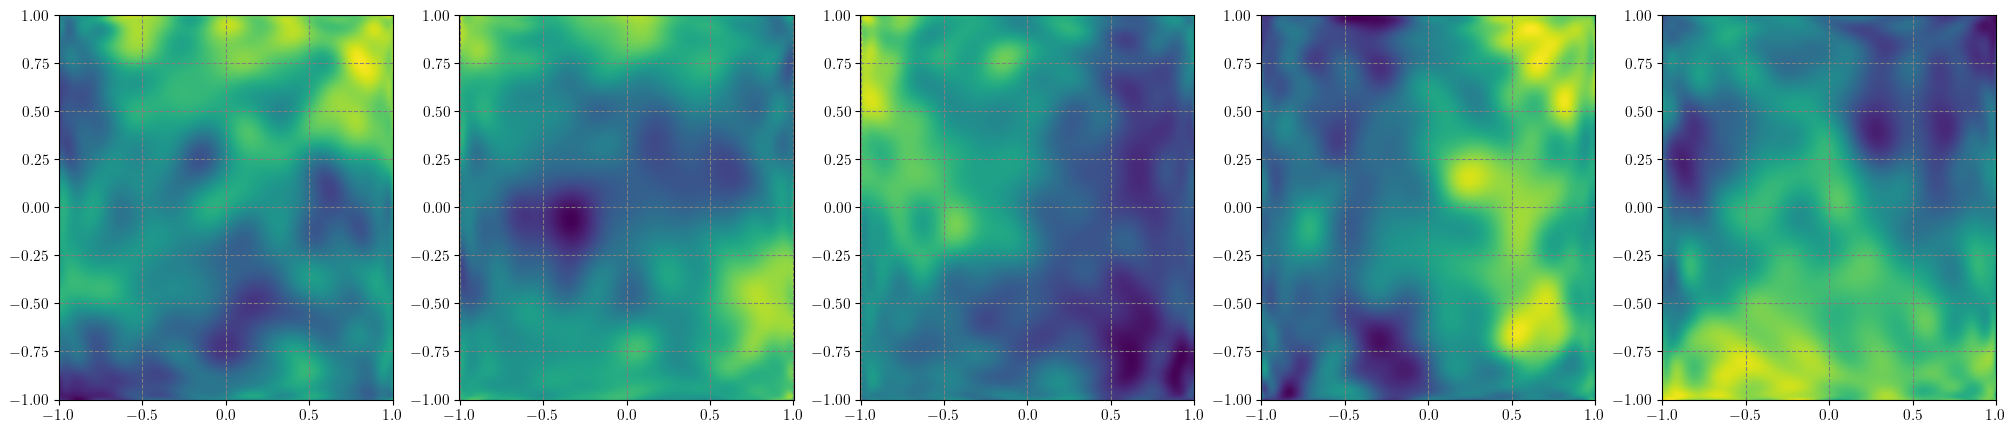

In [20]:
# random realization
n = eigenvectors_functions.shape[0]

plt.figure(figsize=(10, 5))

fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i in range(5):
    realisation = np.random.normal(size=n)
    #print(realisation.shape)
    #print(eigenvectors_functions.T.shape)
    realisation = eigenvectors_functions.T @ realisation

    axs[i].pcolormesh(x_axis, x_axis, realisation)
    
plt.show()
#
#
#plt.title('Random realization')
#plt.xlabel('x')
#plt.ylabel('f(x)')

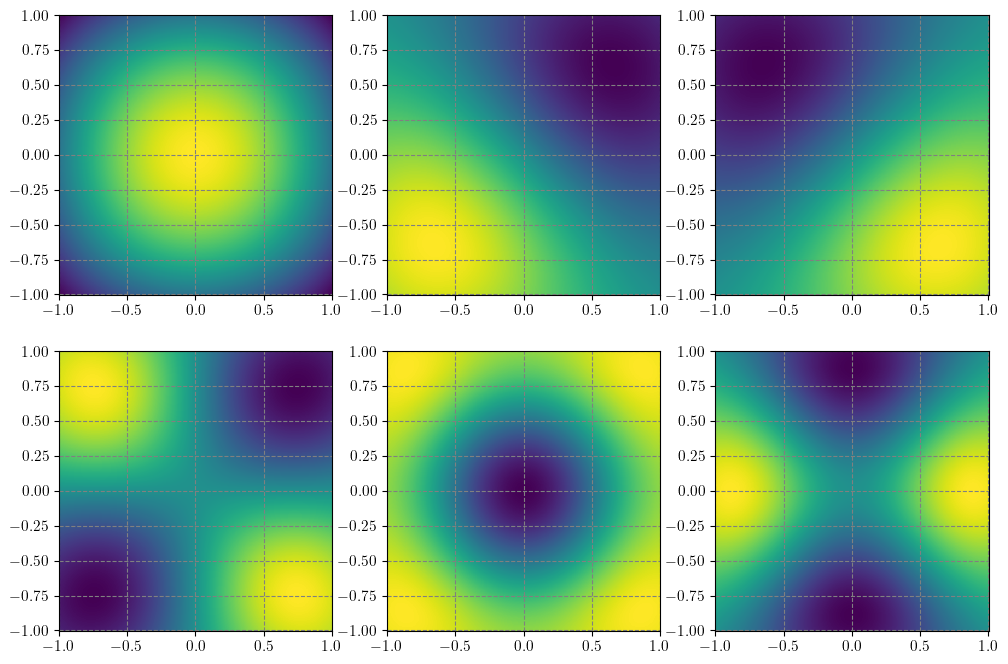

In [21]:
x = np.linspace(-1, 1, 500)


def C(x1,x2,y1,y2):
    dist_sq = (x1 - x2)**2 + (y1 - y2)**2
    return np.exp(-np.sqrt(dist_sq))
eigenfunctions = kl.get_eigenfuntions(x, C, 30, 80)
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i in range(6):
    if(i<3): 
        axs[0,i].pcolormesh(x, x, eigenfunctions[-i-1])
    else:
        axs[1,i-3].pcolormesh(x, x, eigenfunctions[-i-1])
plt.show()

<Figure size 1000x500 with 0 Axes>

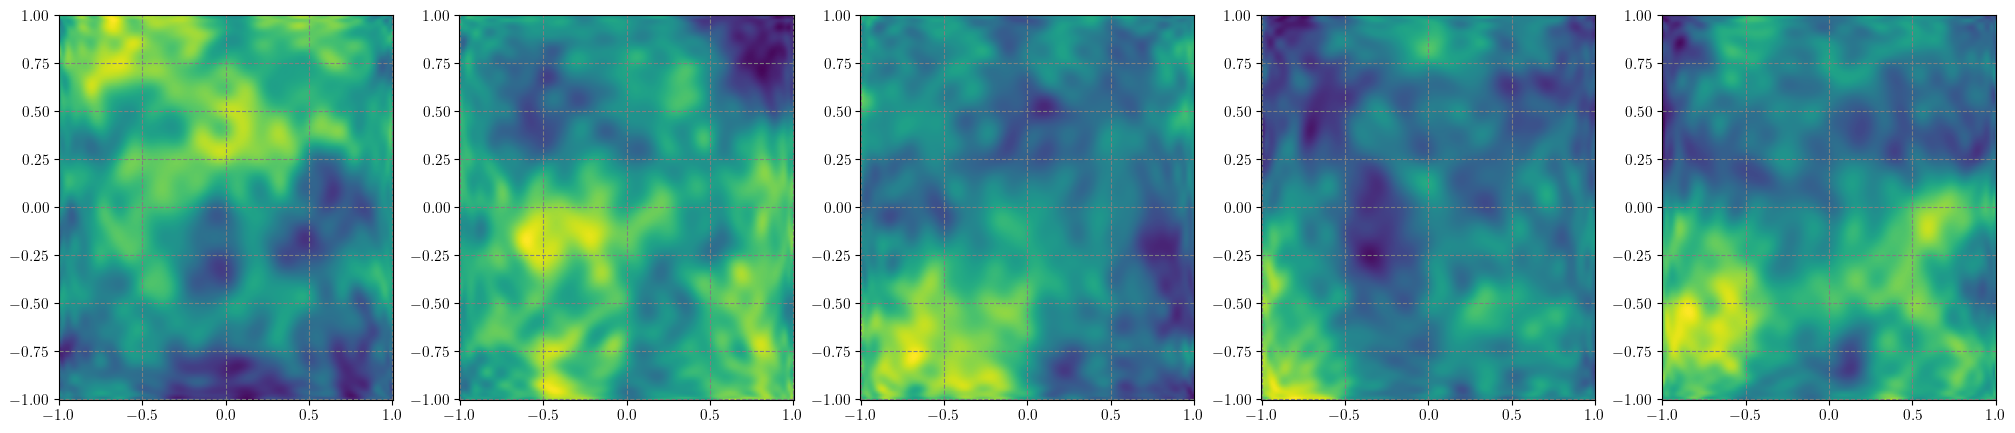

In [22]:
n = eigenfunctions.shape[0]

plt.figure(figsize=(10, 5))

fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i in range(5):
    realisation = kl.sample_normal(eigenfunctions)

    axs[i].pcolormesh(x, x, realisation)
    
plt.show()

Lets see how of the integrals of same polynomials with a C_tensor look like as graphs

In [23]:
l = lambda x : kl.integ.legendre_normal(x, 100)

In [24]:
n = 10

lamb = 10
aprox = []
node_range = range(20,100)
#node_range = range(1,n+20)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-np.sqrt(dist_sq)/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)

Integral result:

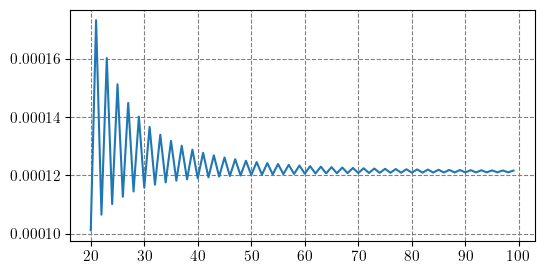

In [25]:
plt.plot(node_range,aprox)
plt.show()

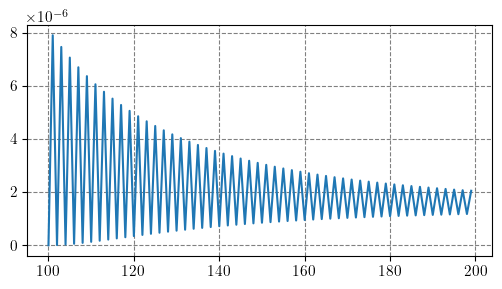

In [26]:
n = 100

lamb = 1
aprox = []
node_range = range(100,200)
#node_range = range(250,300)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-np.sqrt(dist_sq)/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)
plt.plot(node_range,aprox)
plt.show()

### Lets have a different C

In [27]:
n = 4

lamb = 1
aprox = []
difference = []
node_range = range(15,100)
#node_range = range(1,n+20)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-dist_sq/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)
    difference.append(np.abs(int_aprox-0.0164274897245295915177756431842263468086376299790787366359421403395269788))

Integral result:

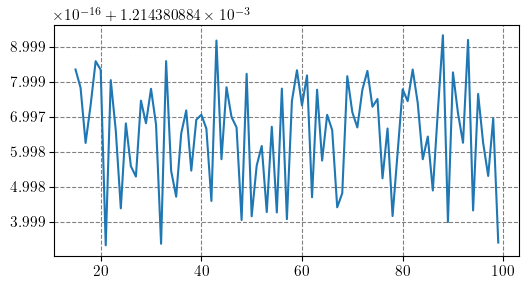

In [28]:
plt.plot(node_range,aprox)
plt.show()

Difference from real value:

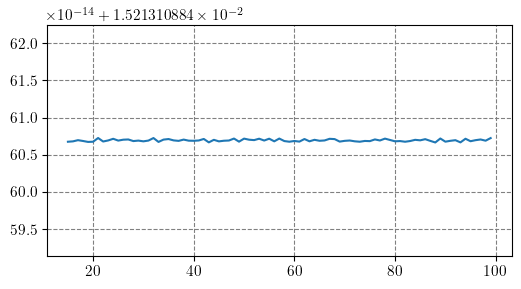

In [29]:
plt.plot(node_range,difference)
plt.show()

In [30]:
n = 4

lamb = 1
aprox = []
difference = []
times = []
node_range = range(15,500)
#node_range = range(1,n+20)
for node_count in node_range:
    starttime = time.time()
    nodes, weights = kl.integ.nodes_weights(node_count)
    dist_sq = (nodes)**2
    C_tensor = np.exp(-dist_sq/lamb)
    #int_aprox = np.einsum('j,jk,k->', l(nodes)[n], C_tensor, l(nodes)[n])
    int_aprox =((l(nodes)[n]*weights) @ C_tensor)**2
    endtime = time.time()

    aprox.append(int_aprox)
    difference.append(np.abs(int_aprox-0.0164274897245295915177756431842263468086376299790787366359421403395269788))
    times.append(endtime-starttime)


Integral result:

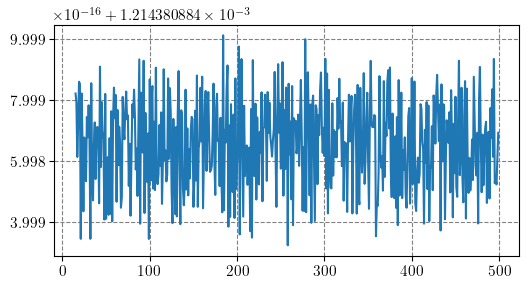

In [31]:
plt.plot(node_range,aprox)
plt.show()

Difference from real value:

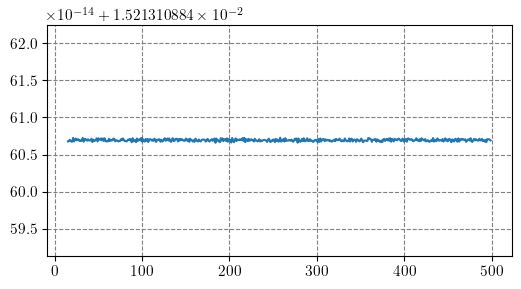

In [32]:
plt.plot(node_range,difference)
plt.show()

Time graph

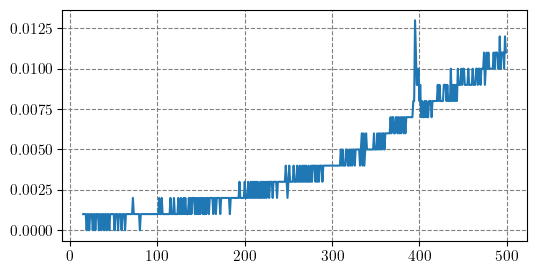

In [33]:
plt.plot(node_range,times)
plt.show()